In [47]:
import string
import pickle
import imblearn
from utils import *
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, auc, roc_curve, brier_score_loss
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

Preprocessing
---


In [48]:
filepath = './data/Kenya_Bill_Text_ID.csv'
df = preprocess_kenyan_bills(filepath)

In [49]:
df.columns

Index(['1ST READ', '2ND READ', '3RD READ', 'ASSENT', 'BILL', 'DATECIRC',
       'DATED', 'GAZETTE NO.', 'MATURITY', 'NA BILL/NO.', 'REMARKS', 'SPONSOR',
       'SUPP NO.', 'TEXT', 'BILL_ID', 'LABEL', 'YEAR', 'MONTH'],
      dtype='object')

More features
---

In [50]:
# confirmed from http://www.parliament.go.ke/index.php/the-national-assembly/mps

other_hons = ['joseph limo', "kimani ichung'wa", 'maina kamanda', 'mutava musyimi', 'benjamin langat',\
             'samuel chepkonga', "samuel chepkong'a", 'rachel nyamai', 'rachael nyamai', 'jeremiah kioni',\
             "benjamin lang'at", "kimani ichungw'ah", 'joseph lekuton', 'moses lessonet', 'asman kamama',\
             'john olago aluoch', 'amina abdalla', 'ephraim m. maina', 'jared odhiambo opiyo', 'eugene wamalwa',\
             'waititu francis munyua', 'julius melly', 'victor munyaka', 'j.k. limo', 'andrew mwadime',\
             'florence mutua', 'david kangogo bowen', 'ayub savula', 'w.k. ottichilo']

In [51]:
house_members = []
att_gen_minister = []

for i in df['SPONSOR']:
    if 'member of parliament' in str(i):
        house_members.append(i)
    elif str(i).startswith('hon.'):
        house_members.append(i)
    elif 'aden duale' in str(i) or 'aden aduale' in str(i):
        house_members.append(i)
    elif 'aden dualle' in str(i):
        house_members.append(i)
    elif any(hon in str(i) for hon in other_hons):
        house_members.append(i)


for i in df['SPONSOR']:
    if 'minister' in str(i) or 'ministry' in str(i):
        att_gen_minister.append(i)
    elif 'attorney general' in str(i):
        att_gen_minister.append(i)
    elif 'attorney-general' in str(i):
        att_gen_minister.append(i)

others = [i for i in df['SPONSOR'] if i not in house_members and i not in att_gen_minister]

In [52]:
print('Total sponsors = ' , len(list(df['SPONSOR'])))
print('Total house_members = ' , len(house_members))
print('Total att_gen_minister = ' , len(att_gen_minister))
print('Total others = ' , len(others))

Total sponsors =  460
Total house_members =  349
Total att_gen_minister =  109
Total others =  9


In [53]:
# 0 - sponsor is a house member of parliament
# 1 - sponsor is attorney general or minister
sponsors2 = []
for i, sponsor in enumerate(list(df['SPONSOR'])):
    if sponsor in house_members:
        sponsors2.append(0)
    elif sponsor in att_gen_minister:
        sponsors2.append(1)
    else:
        sponsors2.append(sponsor)

In [54]:
# 1 - sponsor is 'aden duale'
# 0 - sponsor is not 'aden duale'
sponsors = []
for i, sponsor in enumerate(list(df['SPONSOR'])):
    if 'aden duale' in str(sponsor):
        sponsors.append(1)
    elif type(sponsor) == float:
        sponsors.append(sponsor)
    else:
        sponsors.append(0)

In [55]:
bill_titles = list(df['BILL'].apply(clean_title))
bill_titles_vocab  = []
for i in bill_titles:
    bill_titles_vocab.extend(i.split())

bill_titles_vocab = set(bill_titles_vocab)

In [56]:
dimension = 100
embeddings_matrix = get_glove(bill_titles_vocab, dimension)

In [57]:
feature_df = pd.DataFrame()

In [58]:
feature_df['bill'] = df['BILL']
feature_df['text'] = df['TEXT']
feature_df['year_introduced'] = df['YEAR']
feature_df['month'] = df['MONTH']
feature_df['year_diff'] = 2020 - df['YEAR']
feature_df['text_length'] = df['TEXT'].apply(len_text)
feature_df['label'] = df['LABEL']
feature_df['sponsor'] = sponsors
feature_df['sponsor2'] = sponsors2
feature_df['len_of_title'] = df['BILL'].apply(title_len)
feature_df['title_avg_word_vector'] = df['BILL'].apply(lambda x: extract_embedding_feature(embeddings_matrix, 100, x))
feature_df['text_avg_word_vector'] = df['TEXT'].apply(lambda x: extract_embedding_feature(embeddings_matrix, 100, x))
feature_df['verdict'] = df['REMARKS'].apply(extract_bill_remark)

feature_df[['sponsor', 'sponsor2']] = feature_df[['sponsor', 'sponsor2']].astype('Int64')
feature_df[['month', 'year_introduced', 'year_diff', 'text_length', 'len_of_title']] = feature_df[['month', 'year_introduced','year_diff', 'text_length', 'len_of_title']].astype('int')

In [59]:
feature_df['sponsor'] = feature_df['sponsor'].fillna(feature_df['sponsor'].mode()[0])
feature_df['sponsor2'] = feature_df['sponsor2'].fillna(feature_df['sponsor2'].mode()[0])

In [60]:
# 0 - bill not introduced in an election year
# 1 - bill introduced in an election year

election_years = [2002, 2007, 2013, 2017]
election_year_bill = [1 if year in election_years else 0 for i, year in enumerate(feature_df['year_introduced'])]
feature_df['election_year_bill'] = election_year_bill

Text(0.5, 1.0, 'Bills passed vs bills not passed')

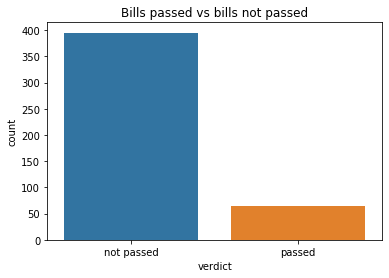

In [61]:
sns.countplot(feature_df['verdict'])
plt.title('Bills passed vs bills not passed')

EDA
---

---
- Sponsors

In [62]:
print(feature_df['sponsor'].value_counts())
print(f'\n{feature_df.sponsor.value_counts().values[0]} sponsors are not aden duale')
print(f'{feature_df.sponsor.value_counts().values[1]} sponsors are aden duale')

0    338
1    122
Name: sponsor, dtype: int64

338 sponsors are not aden duale
122 sponsors are aden duale


---
- Sponsor2

In [63]:
print(feature_df['sponsor2'].value_counts())
print(f'\n{feature_df.sponsor2.value_counts().values[0]} sponsors are members of the house of parliament')
print(f'{feature_df.sponsor2.value_counts().values[1]} sponsors are either ministers or attorney generals')

0    358
1    102
Name: sponsor2, dtype: int64

358 sponsors are members of the house of parliament
102 sponsors are either ministers or attorney generals


In [64]:
feature_df.isna().sum()

bill                     0
text                     0
year_introduced          0
month                    0
year_diff                0
text_length              0
label                    0
sponsor                  0
sponsor2                 0
len_of_title             0
title_avg_word_vector    0
text_avg_word_vector     0
verdict                  0
election_year_bill       0
dtype: int64

In [65]:
feature_df['sponsor'] = feature_df['sponsor'].fillna(feature_df['sponsor'].mode()[0])
feature_df['sponsor2'] = feature_df['sponsor2'].fillna(feature_df['sponsor2'].mode()[0])

In [66]:
feature_df.isna().sum()

bill                     0
text                     0
year_introduced          0
month                    0
year_diff                0
text_length              0
label                    0
sponsor                  0
sponsor2                 0
len_of_title             0
title_avg_word_vector    0
text_avg_word_vector     0
verdict                  0
election_year_bill       0
dtype: int64

---
- Year introduced

In [67]:
print(feature_df['year_introduced'].value_counts())

2012    88
2015    61
2011    57
2019    56
2017    42
2013    40
2014    38
2016    36
2018    21
2009    16
2010     5
Name: year_introduced, dtype: int64


In [68]:
def str_index(index, months):
    index = str(index)
    month = 'NA'
    if len(index) != 2:
        index = '0' + index
    if index != '00':
        month = list(months.keys())[list(months.values()).index(index)]
    return month

index = list(pd.DataFrame(feature_df['month'].value_counts()).index)
months_count = list(pd.DataFrame(feature_df['month'].value_counts())['month'])

---
- Month introduced

In [69]:
months_df = pd.DataFrame()
months_df['month'] = index
months_df['month'] = months_df['month'].apply(lambda x: str_index(x, months))
months_df['count'] = months_count
months_df

,month,count
0,june,61
1,august,58
2,april,53
3,july,45
4,march,43
5,november,40
6,september,37
7,december,32
8,february,27
9,october,23


Most bills were introduced in June, August and April

In [70]:
#replace month 0 with the most common month i.e June(6)
feature_df['month'] = feature_df['month'].astype('int')
feature_df['month'] = feature_df['month'].replace(to_replace=0,value=6)

index = list(pd.DataFrame(feature_df['month'].value_counts()).index)
months_count = list(pd.DataFrame(feature_df['month'].value_counts())['month'])

months_df = pd.DataFrame()
months_df['month'] = index
months_df['month'] = months_df['month'].apply(lambda x: str_index(x, months))
months_df['count'] = months_count
months_df

,month,count
0,june,67
1,august,58
2,april,53
3,july,45
4,march,43
5,november,40
6,september,37
7,december,32
8,february,27
9,october,23


---
- Election year or not

In [71]:
print(feature_df['election_year_bill'].value_counts())
print(f'\n{feature_df.election_year_bill.value_counts().values[0]} bills were not introduced in an election year')
print(f'{feature_df.election_year_bill.value_counts().values[1]} bills were introduced in an election year')

0    378
1     82
Name: election_year_bill, dtype: int64

378 bills were not introduced in an election year
82 bills were introduced in an election year


---
- Labels

In [72]:
feature_df['label'].value_counts()

government operation and international affairs    150
laws, civil rights, safety and security           100
trade, commerce and macro economics                59
labour, sports and social welfare                  44
health and agriculture                             38
public land, housing and transportation            24
education, research and technology                 23
energy, environment and natural resources          22
Name: label, dtype: int64

---
- Average title length

In [73]:
avg_title_len = round(sum(list(feature_df['len_of_title']))/len(feature_df['len_of_title']))
print(f'The average title length is {avg_title_len}')

The average title length is 32


In [74]:
len(feature_df)

460

In [75]:
feature_df['verdict'].value_counts()

not passed    395
passed         65
Name: verdict, dtype: int64

There is a class imbalance in the dataset with only 65 bills passed and 386 bills not passed.

In [76]:
X, y = feature_df.drop(['verdict', 'bill', 'text'], axis=1), feature_df['verdict']

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

label_col_encoder = LabelEncoder()
X_train['label'] = label_col_encoder.fit_transform(X_train.label)
X_test['label'] = label_col_encoder.transform(X_test.label)

In [78]:
feature_df['verdict'].value_counts()

not passed    395
passed         65
Name: verdict, dtype: int64

In [79]:
labels_df = feature_df.groupby('label').agg({'verdict': 'count'}).reset_index()
labels_df

,label,verdict
0,"education, research and technology",23
1,"energy, environment and natural resources",22
2,government operation and international affairs,150
3,health and agriculture,38
4,"labour, sports and social welfare",44
5,"laws, civil rights, safety and security",100
6,"public land, housing and transportation",24
7,"trade, commerce and macro economics",59


In [80]:
enacted_df = feature_df[feature_df.verdict == 'passed']
not_enacted_df = feature_df[feature_df.verdict != 'passed']

In [81]:
grouped_enacted_df = enacted_df.groupby('label').agg({'verdict': 'count'}).reset_index()
grouped_enacted_df

,label,verdict
0,"education, research and technology",1
1,"energy, environment and natural resources",8
2,government operation and international affairs,21
3,health and agriculture,6
4,"labour, sports and social welfare",4
5,"laws, civil rights, safety and security",13
6,"public land, housing and transportation",4
7,"trade, commerce and macro economics",8


In [82]:
grouped_not_enacted_df = not_enacted_df.groupby('label').agg({'verdict': 'count'}).reset_index()
grouped_not_enacted_df

,label,verdict
0,"education, research and technology",22
1,"energy, environment and natural resources",14
2,government operation and international affairs,129
3,health and agriculture,32
4,"labour, sports and social welfare",40
5,"laws, civil rights, safety and security",87
6,"public land, housing and transportation",20
7,"trade, commerce and macro economics",51


Models
---

In [83]:
text_col = np.array([X_train['text_avg_word_vector']])
title_col = np.array([X_train['title_avg_word_vector']])
shape = title_col.shape

text_col = text_col.reshape(shape[1], shape[2])
title_col = title_col.reshape(shape[1], shape[2])

print(f'text_col shape: {text_col.shape}\ntitle_col shape: {title_col.shape}')

X_train = X_train.drop(['title_avg_word_vector', 'text_avg_word_vector'], axis=1)

text_col shape: (322, 100)
title_col shape: (322, 100)


In [84]:
pd.value_counts(y_train)

0    276
1     46
dtype: int64

In [85]:
smote = SMOTE(random_state=1, k_neighbors=6)

text_col_smote, y_smote = smote.fit_resample(text_col, y_train)
title_col_smote, y_smote = smote.fit_resample(title_col, y_train)
X_train_smote = smote.fit_sample(X_train, y_train)

X_train_smt_df = pd.DataFrame(X_train_smote[0], columns=X_train.columns)
y_train_smt_df = pd.DataFrame(X_train_smote[1], columns=['verdict'])

X_train_smt_df['title_avg_word_vector'] = title_col_smote.tolist()
X_train_smt_df['text_avg_word_vector'] = text_col_smote.tolist()

In [86]:
pd.value_counts(y_smote)

1    276
0    276
dtype: int64

In [87]:
class NumberSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[[self.column]]

class WordVectorSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        vec = np.array([X[self.column]])
        shape = vec.shape
        vec = np.array([vec]).reshape(shape[1], shape[2])
        return vec

In [88]:
estimators = [('lr', LogisticRegression(C=4, solver='liblinear')),('svc', SVC(probability=True))]
stacked_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), verbose=3, 
                cv=StratifiedKFold(n_splits=5, random_state=0))

In [89]:
model = Pipeline([
    ('union', FeatureUnion(
        transformer_list = [
            ('year_diff', Pipeline([
                ('selector', NumberSelector(column='year_diff')),
                ('standard', StandardScaler())
            ])),
            ('year_introduced', Pipeline([
                ('selector', NumberSelector(column='year_introduced')),
            ])),
            ('len_of_title', Pipeline([
                ('selector', NumberSelector(column='len_of_title')),
                ('standard', StandardScaler())
            ])),
            ('text_length', Pipeline([
                ('selector', NumberSelector(column='text_length')),
                ('standard', StandardScaler())
            ])),
            ('sponsor', Pipeline([
                ('selector', NumberSelector(column='sponsor')),
            ])),
            ('sponsor2', Pipeline([
                ('selector', NumberSelector(column='sponsor2')),
            ])),
            ('month', Pipeline([
                ('selector', NumberSelector(column='month')),
            ])),
            ('label', Pipeline([
                ('selector', NumberSelector(column='label')),
            ])),
            ('title_avg_word_vector', Pipeline([
                ('selector', WordVectorSelector('title_avg_word_vector'))
            ])),
            ('text_avg_word_vector', Pipeline([
                ('selector', WordVectorSelector('text_avg_word_vector'))
            ]))
        ]
    )),
    ('clf', stacked_clf)
])

In [90]:
model.fit(X_train_smt_df, y_train_smt_df)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.9s finished


Pipeline(memory=None,
         steps=[('union',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('year_diff',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  NumberSelector(column='year_diff')),
                                                                 ('standard',
                                                                  StandardScaler(copy=True,
                                                                                 with_mean=True,
                                                                                 with_std=True))],
                                                          verbose=False)),
                                                ('year_introduced',
                                                 Pipeline(memory=None,
               

In [91]:
preds = model.predict(X_test)
pred_prob = model.predict_proba(X_test)

In [92]:
target_names = ['not passed', 'passed']
print(f'\n{classification_report(y_true=y_test, y_pred=preds, target_names=target_names)}')

fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=pred_prob[:, 0], pos_label=0)
auc_value = auc(fpr, tpr)

brier_score = brier_score_loss(y_true=y_test, y_prob=pred_prob[:, 0], pos_label=0)

print(f'\nAUC: {round(auc_value, 2)}')
print(f'Brier score: {round(brier_score, 2)} \n')


              precision    recall  f1-score   support

  not passed       0.93      0.85      0.89       119
      passed       0.38      0.58      0.46        19

    accuracy                           0.81       138
   macro avg       0.65      0.71      0.67       138
weighted avg       0.85      0.81      0.83       138


AUC: 0.73
Brier score: 0.15 

